# Calculate Arctic Regional ice state from Rufmod experiments

* **Description**: Reads in and creates regional integrated values from rufmod experiment
* **Input data**: Rufmod output in timeseries format
* **Output data**: Netcdf with processed ice state for all members
* **Creator**: Alice DuVivier
* **Date**: August 2021

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature


## Get grid stuff

In [2]:
# Grid
ds_grid = xr.open_dataset('/glade/p/cesm/omwg/grids/gx1v7_grid.nc')

In [3]:
TLAT = ds_grid['TLAT']
TLONG = ds_grid['TLONG']

## Get masks

In [4]:
# Load in masks
mask_in = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask']

ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/REGION_MASK_gx1v7.nc')
ds_masks=ds_masks.rename({'lat':'nj','lon': 'ni'})
my_mask = ds_masks[mask_in].isel(time=0)

# now load in the different masks as a new coordinate
masks=xr.concat([my_mask.nh_mask,my_mask.Lab_mask,my_mask.GIN_mask,my_mask.Bar_mask,my_mask.ArcOc_mask,my_mask.Sib_mask,my_mask.Beau_mask,my_mask.Bering_mask,my_mask.Hudson_mask,my_mask.CAArch_mask,my_mask.Okhotsk_mask],dim='region')
masks['region']=mask_in

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Lab_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'GIN_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Bar_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'ArcOc_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decod

In [5]:
masks.region

<xarray.DataArray 'region' (region: 11)>
array(['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask',
       'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask',
       'Okhotsk_mask'], dtype='<U12')
Coordinates:
  * region   (region) <U12 'nh_mask' 'Lab_mask' ... 'CAArch_mask' 'Okhotsk_mask'

In [6]:
masks

<xarray.DataArray 'nh_mask' (region: 11, nj: 384, ni: 320)>
dask.array<concatenate, shape=(11, 384, 320), dtype=float32, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * region   (region) <U12 'nh_mask' 'Lab_mask' ... 'CAArch_mask' 'Okhotsk_mask'
Dimensions without coordinates: nj, ni

In [7]:
# rename some coordinates so things work properly!
TLAT = TLAT.rename({'nlat':'nj', 'nlon':'ni'})
TLONG = TLONG.rename({'nlat':'nj', 'nlon':'ni'})

## Plot mask

In [8]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ArcOc_mask


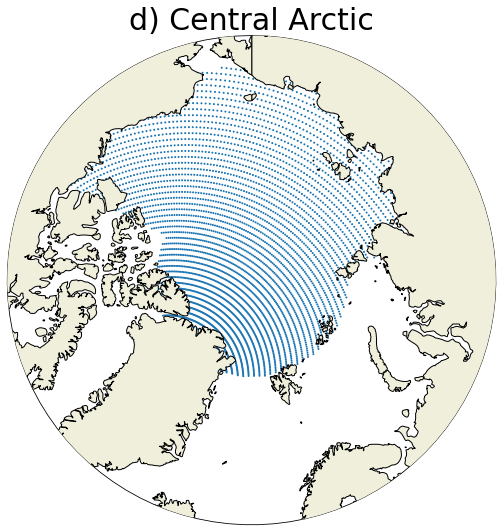

In [10]:
for reg in mask_in[4:5]:
    print(reg)
    mask_choice = masks.sel(region=reg)
    
    # Want to plot the mask
    fig = plt.figure(figsize=(12,9))

    ax = plt.subplot(1,1,1,projection = ccrs.NorthPolarStereo() )
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())

    # doing scatter for now
    cs1 = ax.scatter(TLONG.values, TLAT.values, 
                     mask_choice,
                     cmap='Blues',vmin=0,vmax=1,
                     transform=ccrs.PlateCarree())

    ax.set_title("d) Central Arctic", fontsize=30)
    fig = plt.savefig(reg+'.png', bbox_inches='tight', dpi=200)